In [1]:
import tiktoken
import torch
import torch.nn.functional as F

from src.configs import GPT_CONFIG_124M_256, GPT_CONFIG_124M_1024
from src.dataset.gpt_dataset_v1 import GPTDatasetV1
from src.model.llm.gpt2 import GPT2Model
from src.utils.loss import compute_full_loss
from src.utils.plot import plot_losses
from src.utils.text_generation import generate_text_simple
from src.utils.text_tokenization import text_to_token_ids, token_ids_to_text
from src.utils.training import train_model_simple

In [2]:
torch.manual_seed(123)
model = GPT2Model(GPT_CONFIG_124M_256)
model.eval()

GPT2Model(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForwardEqual(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNormalization()
      (norm2): LayerNormalization()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiHeadAttention(
        (

In [3]:
start_context = 'Every effort moves you'
tokenizer = tiktoken.get_encoding('gpt2')

token_ids = generate_text_simple(
    model=model,
    token_idxes=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M_256['context_length']
)
print('Output text:\n', token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [4]:
inputs = torch.tensor(
    [
        [16833, 3626, 6100],
        [40, 1107, 588],
    ]
)

targets = torch.tensor(
    [
        [3626, 6100, 345],
        [588, 428, 11311],
    ]
)

In [5]:
with torch.no_grad():
    logits = model(inputs)
probs = torch.softmax(logits, dim=-1)
print(probs.shape)

torch.Size([2, 3, 50257])


In [6]:
token_ids = torch.argmax(probs, dim=-1, keepdim=True)
print('Token IDs:\n', token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [7]:
target_probs0 = probs[0, [0, 1, 2], targets[0]]
target_probs1 = probs[1, [0, 1, 2], targets[1]]

In [8]:
log_probs = torch.log(torch.cat((target_probs0, target_probs1)))
print(log_probs)

tensor([ -9.5042, -10.3796, -11.3677, -10.1308, -10.9951, -12.2561])


In [9]:
avg_log_probs = torch.mean(log_probs)
print(avg_log_probs)

tensor(-10.7722)


In [10]:
neg_avg_log_probs = -1 * avg_log_probs
print(neg_avg_log_probs)

tensor(10.7722)


In [11]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print('logits_flat:\n', logits_flat.shape)
print('targets_flat:\n', targets_flat.shape)

logits_flat:
 torch.Size([6, 50257])
targets_flat:
 torch.Size([6])


In [12]:
loss = F.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7722)


In [13]:
file_path = '../data/the-verdict.txt'
with open(file_path, 'r') as fp:
    text_data = fp.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print('# characters:', total_characters)
print('# tokens:', total_tokens)

# characters: 20479
# tokens: 5145


In [14]:
train_ratio = 0.9
split_idx = int(train_ratio * total_characters)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [15]:
torch.manual_seed(123)

train_dataset = GPTDatasetV1(
    train_data,
    tokenizer,
    GPT_CONFIG_124M_256['context_length'],
    GPT_CONFIG_124M_256['context_length']
)
val_dataset = GPTDatasetV1(
    val_data,
    tokenizer,
    GPT_CONFIG_124M_256['context_length'],
    GPT_CONFIG_124M_256['context_length']
)

In [16]:
train_data_loader = train_dataset.to_data_loader(2, True, False)
val_data_loader = val_dataset.to_data_loader(2, False, False)

In [17]:
print('Train loader:')
for x, y in train_data_loader:
    print(x.shape, y.shape)

print('\n Val loader:')
for x, y in val_data_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

 Val loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [22]:
train_tokens = 0
for input_batch, target_batch in train_data_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_data_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [18]:
device = torch.device('mps')
model.to(device)
with torch.no_grad():
    train_loss = compute_full_loss(train_data_loader, model, device)
    val_loss = compute_full_loss(val_data_loader, model, device)
print('Training loss:', train_loss)
print('Validation loss:', val_loss)

Training loss: tensor(10.9876, device='mps:0')
Validation loss: tensor(10.9811, device='mps:0')


In [23]:
torch.manual_seed(123)
model = GPT2Model(GPT_CONFIG_124M_256)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=4e-4, weight_decay=0.1)

num_epochs = 20
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_data_loader,
    val_data_loader,
    optimizer,
    device,
    num_epochs,
    5,
    5,
    start_context='Every effort moves you',
    tokenizer=tokenizer,
    context_length=GPT_CONFIG_124M_256['context_length']
)

Epoch 1 (Step 000000:
Train Loss: 10.6784
Val Loss: 10.6941
Epoch 1 (Step 000005:
Train Loss: 9.4779
Val Loss: 9.6846
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Epoch 2 (Step 000010:
Train Loss: 8.8302
Val Loss: 9.0604
Epoch 2 (Step 000015:
Train Loss: 8.4065
Val Loss: 8.6267
Every effort moves you, the, the the the the the the the the, the.                                    
Epoch 3 (Step 000020:
Train Loss: 8.0484
Val Loss: 8.2186
Epoch 3 (Step 000025:
Train Loss: 7.6563
Val Loss: 7.8721
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,,,,,,,,,,,
Epoch 4 (Step 000030:
Train Loss: 7.4563
Val Loss: 7.6500
Epoch 4 (Step 000035:
Train Loss: 7.3244
Val Loss: 7.4989
Every effort moves you,,,,,,.                                           
Epoch 5 (Step 000040:
Train Loss: 7.1200
Val Loss: 7.3808
Every effort moves you,,,,,, the the,,,,,,.                                   
Epoch 6 (Step 000045:
Train Loss: 7.0794
Val Loss: 7.2864
Epoch 6 (Step 

In [20]:
epochs = torch.linspace(0, num_epochs, len(train_losses))
print(epochs)
print(len(train_losses))
print(train_losses)

tensor([ 0.0000,  0.5714,  1.1429,  1.7143,  2.2857,  2.8571,  3.4286,  4.0000,
         4.5714,  5.1429,  5.7143,  6.2857,  6.8571,  7.4286,  8.0000,  8.5714,
         9.1429,  9.7143, 10.2857, 10.8571, 11.4286, 12.0000, 12.5714, 13.1429,
        13.7143, 14.2857, 14.8571, 15.4286, 16.0000, 16.5714, 17.1429, 17.7143,
        18.2857, 18.8571, 19.4286, 20.0000])
36
[tensor(10.7501, device='mps:0'), tensor(9.5683, device='mps:0'), tensor(8.7384, device='mps:0'), tensor(8.3223, device='mps:0'), tensor(8.2091, device='mps:0'), tensor(7.5056, device='mps:0'), tensor(7.2931, device='mps:0'), tensor(7.3283, device='mps:0'), tensor(7.0594, device='mps:0'), tensor(7.2088, device='mps:0'), tensor(6.8470, device='mps:0'), tensor(7.0966, device='mps:0'), tensor(6.5856, device='mps:0'), tensor(6.5510, device='mps:0'), tensor(6.7177, device='mps:0'), tensor(6.8558, device='mps:0'), tensor(6.8968, device='mps:0'), tensor(6.3556, device='mps:0'), tensor(6.8593, device='mps:0'), tensor(6.3287, device=

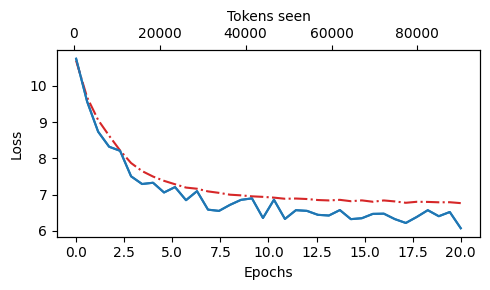

In [21]:
plot_losses(
    epochs,
    tokens_seen,
    [loss.cpu() for loss in train_losses],
    [loss.cpu() for loss in val_losses]
)